In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors
import cv2

***Show the Image***

In [3]:
def show_image_plt(img_rgb):
    #rgb_carrot = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()

def show_image(img):
    cv2.imshow("Image", img)
    cv2.waitKey(5000)
    cv2.destroyAllWindows()

***height (rows), width(cols)***

In [4]:
def resize_image(vegi):
    height, width, c = vegi.shape
    new_height = 100
    ratio = new_height / height 
    new_width = int(width * ratio)
    dimensions = (new_width, new_height)
    print(dimensions)
    resized_img = cv2.resize(vegi, dimensions, interpolation=cv2.INTER_LINEAR)
    print("New shape:      ", resized_img.shape)

    return resized_img

# current values for borders they roughly fit to the real hsv values. I test it for brown onion, carrot, brown potato with
# white background, respectively
def mask_image(img_hsv, img_rgb, border_low=(8, 50, 75), border_high=(15, 255, 160)):
    #15, 23, 135
    mask = cv2.inRange(img_hsv, border_low, border_high)
    result = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

    #plt.subplot(1, 3, 1)
    #plt.imshow(img_rgb)
    #plt.subplot(1, 3, 2)
    #plt.imshow(mask, cmap='gray')
    #plt.subplot(1, 3, 3)
    #plt.imshow(result)
    #plt.show()
    return mask, result
    

def resize_to_square(vegi):
    img_size = 256
    height, width = vegi.shape[:2]
    a1 = width / height
    a2 = height / width

    if (a1 > a2):
        r_img = cv2.resize(vegi, (round(img_size * a1), img_size), interpolation = cv2.INTER_AREA)
        margin = int(r_img.shape[1]/6)
        crop_img = r_img[0:img_size, margin:(margin+img_size)]

    elif(a1 < a2):
        # if height greater than width
        r_img = cv2.resize(vegi, (img_size, round(img_size * a2)), interpolation = cv2.INTER_AREA)
        margin = int(r_img.shape[0]/6)
        crop_img = r_img[margin:(margin+img_size), 0:img_size]

    elif(a1 == a2):
        # if height and width are equal
        r_img = cv2.resize(vegi, (img_size, round(img_size * a2)), interpolation = cv2.INTER_AREA)
        crop_img = r_img[0:img_size, 0:img_size]

    if(crop_img.shape[0] != img_size or crop_img.shape[1] != img_size):
        crop_img = r_img[0:img_size, 0:img_size]

    return crop_img


def flip_image_and_show(img):
    # flip vertical
    img_v = cv2.flip(img, 0)
    #show_image_plt(onion_sq_v)

    #flip horizontal
    img_h = cv2.flip(img, 1)
    #show_image_plt(onion_sq_h)

    #flip vertical + horizontal
    img_vh = cv2.flip(img, -1)
    #show_image_plt(onion_sq_vh)

    fig, axarr = plt.subplots(2, 2) #1 row, 3 cols
    fig.tight_layout(h_pad=4)
    axarr[0][0].imshow(img)
    axarr[0][0].set_title("Original")
    axarr[0][1].imshow(img_v)
    axarr[0][1].set_title("Flip Vertical")
    axarr[1][0].imshow(img_h)
    axarr[1][0].set_title("Flip Horizontal")
    axarr[1][1].imshow(img_vh)
    axarr[1][1].set_title("Flip Vertical + Horizontal")
    fig.suptitle('Flipped Images')
    plt.subplots_adjust(top = 0.85)


def rotate_image_and_show(img):
    # rotate 90 degree clockwise
    img_r90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    #show_image_plt(onion_sq_v)

    #rotate 180 degree
    img_r180 = cv2.rotate(img, cv2.ROTATE_180)
    #show_image_plt(onion_sq_h)

    #rotate 90 degree counterclockwise
    img_rcw90 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    #show_image_plt(onion_sq_vh)

    fig, axarr = plt.subplots(2, 2) #2 row, 2 cols
    fig.tight_layout(h_pad=4)

    axarr[0][0].imshow(img)
    axarr[0][0].set_title("Original")
    axarr[0][1].imshow(img_r90)
    axarr[0][1].set_title("+ 90")
    axarr[1][0].imshow(img_r180)
    axarr[1][0].set_title("+ 180")
    axarr[1][1].imshow(img_rcw90)
    axarr[1][1].set_title("- 90")

    fig.suptitle('Rotated Images')
    plt.subplots_adjust(top = 0.85)


def draw_bounding_box(img, low_threshold, high_threshold):
    # the thresholds are used as gradients thresholds. 
    # Something like, gradients smaller than the low_threshold or between the thresholds are ignored 
    result = img.copy()
    gray_square_onion = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    thresh = cv2.threshold(gray_square_onion, low_threshold, high_threshold, cv2.THRESH_BINARY)[1]

    # get contours
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        # The idea is only keep bigger bounding boxes. Probably it presents the object
        if w > 22 and h > 0.5:
            cv2.rectangle(result, (x, y), (x+w, y+h), (100, 0, 255), 1)
            ROI = img[y:y+h, x:x+w]
            print(f"ROI:. Size of Bounding Box: w = {w} / h = {h}")
        else:
            continue
    show_image_plt(result)


def plot_color_space_rgb_to_hsv(img_rgb, convert_to_hsv=True):
    copy_rgb = img_rgb.copy()
    img_hsv = copy_rgb
    x_label = "R (X)"
    y_label = "G (Y)"
    z_label = "B (Z)"

    if convert_to_hsv:
        img_hsv = cv2.cvtColor(copy_rgb, cv2.COLOR_RGB2HSV)
        x_label = "Hue X"
        y_label = "Saturation Y"
        z_label = "Value Z"

    pixel_colors = copy_rgb.reshape((np.shape(copy_rgb)[0]*np.shape(copy_rgb)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()

    x, y, z = cv2.split(img_hsv)
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")

    axis.scatter(x.flatten(), y.flatten(), z.flatten(), facecolors=pixel_colors, marker=".")
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)
    axis.set_zlabel(z_label)
    plt.show()


def print_color_values(img):
    for row in range(0, img.shape[1]):
        for col in range(0, img.shape[1]):
            print(f"Row {row}: Spalte {col} {img[row, col]}")

def kMeans(img_rgb, number_of_clusters, attempts):
    # KMeans Processing
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    K = number_of_clusters
    onion_2D = img_hsv.reshape((-1,3)) #Reshape to 2 dimensional image (65536, 3)
    onion_2D = np.float32(onion_2D)

    CONSTANT_1 = 10
    CONSTANT_2 = 1.0
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, CONSTANT_1, CONSTANT_2)

    ret, label, center=cv2.kmeans(onion_2D, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img_rgb.shape))

    return result_image, label, center

#Expect gray img
def min_area_rect(img_rgb, low_thresh, high_thresh):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    #gray = img_rgb.copy()
    #gray = cv2.blur(gray, (3,3))

    #plt.imshow(gray, cmap='gray')
    #plt.show()

    # Use Otsu's method to calculate a dynamic threshold
    #a, thresh = cv2.threshold(gray, low_thresh, high_thresh, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #print(thresh.min(), thresh.max())
    #thresh_low = 0.5 * thresh
    #thresh_high = 1.5 * thresh
    # Apply edge detection using the dynamic threshold
    edges = cv2.Canny(gray, low_thresh, high_thresh)
    
    # Find contours in the edged image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print('Length Contours: ', len(contours))
    # Find the contour with the maximum area
    max_contour = max(contours, key=cv2.contourArea)
    #print(contours)
    # Get the rotated bounding box of the contour
    rect = cv2.minAreaRect(max_contour)
    box = cv2.boxPoints(rect)
    box = np.intp(box)
    
    # Draw the rotated bounding box on the original image
    result_image = img_rgb.copy()
    cv2.drawContours(result_image, [box], 0, (0, 255, 0), 2)
    thres = 10
    return result_image, thres, box

def get_object_color(center, cluster_img_hsv):
    for point in center:
        edge_point = 0
        if (point == cluster_img_hsv[0][0]).all():
            edge_point += 1

        if (point == cluster_img_hsv[0][255]).all():
            edge_point += 1

        if (point == cluster_img_hsv[255][255]).all():
            edge_point += 1

        if (point == cluster_img_hsv[255][0]).all():
            edge_point += 1

        if edge_point >= 3:
            #print(f"Color Background found: {point}")
            pass

        if edge_point < 3:
            #print(f"Color Object found: {point}")
            return point

https://realpython.com/python-opencv-color-spaces/

The Code below is for data augmentation. It is a technique for enlarging a dataset.
It will use the standard techniques like horizontal & vertical flipping and rotation.

Load Images from personal cloud storage

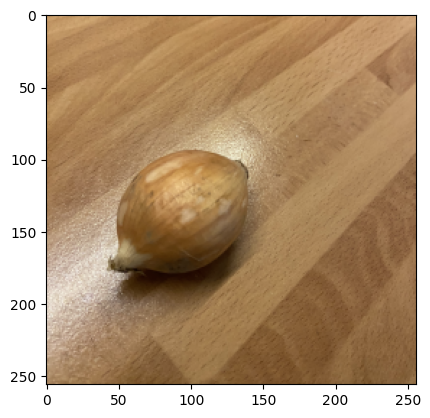

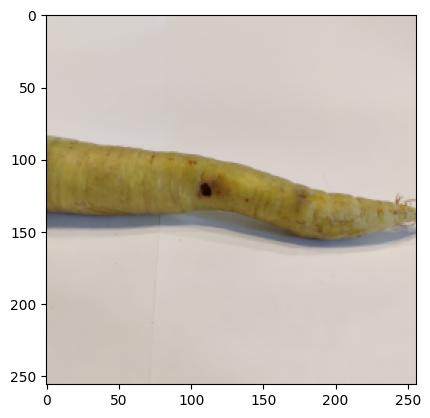

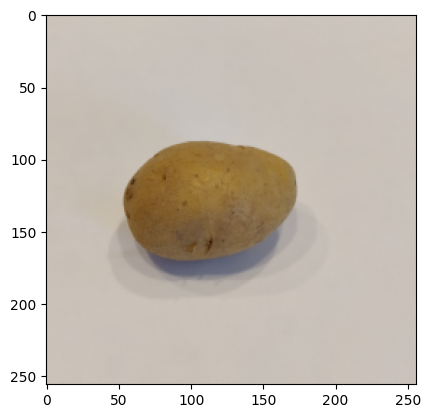

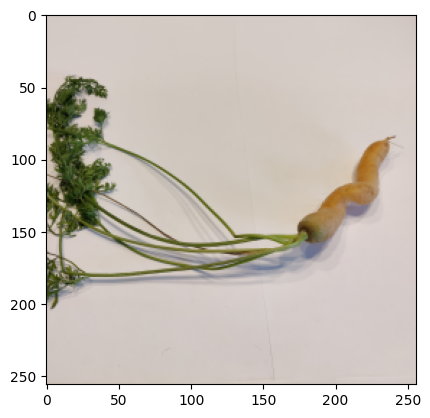

In [4]:
path = "G:\Meine Ablage\Images_AI_Project\zwiebel_jpg\zwiebel_1.jpg"
onion = cv2.imread(path.replace("\\","/"))
onion = cv2.cvtColor(onion, cv2.COLOR_BGR2RGB)

path = "G:\Meine Ablage\KI_Projekt\Bilder\Karotte\karotte_107.jpg"
carrot = cv2.imread(path.replace("\\","/"))
carrot = cv2.cvtColor(carrot, cv2.COLOR_BGR2RGB)

path = "G:\Meine Ablage\Images_AI_Project\karotte_jpg\karotte_trieb_13.jpg"
carrot_trieb = cv2.imread(path.replace("\\","/"))
carrot_trieb = cv2.cvtColor(carrot_trieb, cv2.COLOR_BGR2RGB)

path = "G:\Meine Ablage\Images_AI_Project\kartoffel_jpg\kartoffel_122.jpg"
potato = cv2.imread(path.replace("\\","/"))
potato = cv2.cvtColor(potato, cv2.COLOR_BGR2RGB)

onion_sq = resize_to_square(onion)
carrot_sq = resize_to_square(carrot)
potato_sq = resize_to_square(potato)
carrot_trieb_sq = resize_to_square(carrot_trieb)

show_image_plt(onion_sq)
show_image_plt(carrot_sq)
show_image_plt(potato_sq)
show_image_plt(carrot_trieb_sq)

Applying the median filter https://theailearner.com/tag/cv2-medianblur/

https://machinelearningknowledge.ai/image-segmentation-in-python-opencv/

In [4]:
def kMeans_for_rgb_img(img_rgb, number_of_clusters, attempts):
    # KMeans Processing
    #img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    K = number_of_clusters
    onion_2D = img_rgb.reshape((-1,3)) #Reshape to 2 dimensional image (65536, 3)
    onion_2D = np.float32(onion_2D)

    CONSTANT_1 = 10
    CONSTANT_2 = 1.0
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, CONSTANT_1, CONSTANT_2)

    ret, label, center=cv2.kmeans(onion_2D, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img_rgb.shape))

    return result_image, label, center

def mask_image_rgb(img_rgb, border_low=(8, 50, 75), border_high=(15, 255, 160)):
    #15, 23, 135
    mask = cv2.inRange(img_rgb, border_low, border_high)
    result = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.imshow(result)
    plt.show()
    return mask, result


In [5]:
def run_kmeans(orig_img):
    median_rgb = cv2.medianBlur(orig_img, 9)
    show_image_plt(median_rgb)

    #gaussian_onion = cv2.GaussianBlur(onion_sq,(5,5),0)
    #show_image_plt(gaussian_onion)

    clusterd_img_hsv, label, center = kMeans(median_rgb, number_of_clusters=2, attempts=100)
    plt.imshow(clusterd_img_hsv)
    plt.show()

    return center, clusterd_img_hsv, median_rgb

def run_bounding_box(clusterd_img_hsv, median_rgb, center_object, t_low, t_high):
    masked_img_gray, masked_img_rgb = mask_image(clusterd_img_hsv, median_rgb, border_low=center_object, border_high=center_object) #borders for hsv colorspace
    #print(masked_img_gray)
    result_image, thresh, box = min_area_rect(masked_img_rgb, t_low, t_high)

    plt.imshow(result_image)
    plt.show()

https://docs.opencv.org/4.x/de/d62/tutorial_bounding_rotated_ellipses.html

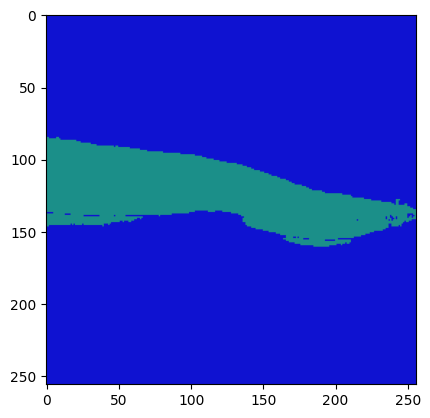

CENTER:  [[ 27 143 137]
 [ 15  18 209]]


In [9]:
centers, clusterd_img_hsv, median_rgb = run_kmeans(carrot_sq)
print("CENTER: ", centers)
#center_object = get_object_color(centers, clusterd_img_hsv)

Length Contours:  16


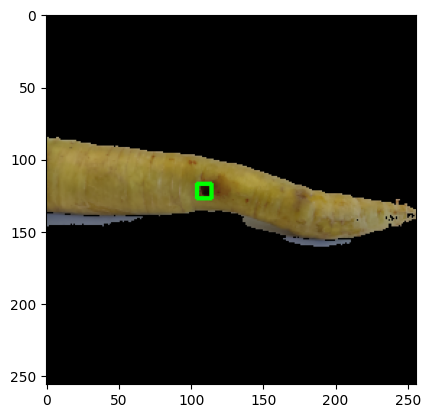

In [11]:
#for val in range(75, 130):
#print("Thres: ", val)
val = 110
run_bounding_box(clusterd_img_hsv, median_rgb, centers[0], val, val*2)

In [224]:
# Find correct center. Assumption: Min 3 Corner points of the image should be part of background
print("Background: ", clusterd_img_hsv[0][0])
print("Object: ", clusterd_img_hsv[100][50])

for point in center:
    edge_point = 0
    if (point == clusterd_img_hsv[0][0]).all():
        edge_point += 1

    if (point == clusterd_img_hsv[0][255]).all():
        edge_point += 1

    if (point == clusterd_img_hsv[255][255]).all():
        edge_point += 1

    if (point == clusterd_img_hsv[255][0]).all():
        edge_point += 1

    if edge_point >= 3:
        print(f"Color Background found: {point}")

    if edge_point < 3:
        print(f"Color Object found: {point}")


Background:  [ 14  23 208]
Object:  [ 15 183 129]
Color Background found: [ 14  23 208]
Color Object found: [ 15 183 129]


In [290]:
def thresh_callback(val, src_gray):
    #print(val)
    threshold = val
    #global src_gray
    canny_output = cv2.Canny(src_gray, threshold, threshold * 2)
    contours, _ = cv2.findContours(canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find the rotated rectangles and ellipses for each contour
    minRect = [None]*len(contours)
    minEllipse = [None]*len(contours)
    for i, c in enumerate(contours):
        minRect[i] = cv2.minAreaRect(c)
        #if c.shape[0] > 5:
        #    minEllipse[i] = cv2.fitEllipse(c)

    # Draw contours + rotated rects + ellipses

    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)

    for i, c in enumerate(contours):
        #color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        color = (0, 255, 0)
        # contour
        #cv2.drawContours(drawing, contours, i, color)
        # ellipse
        #if c.shape[0] > 5:
        #    cv2.ellipse(drawing, minEllipse[i], color, 2)
        # rotated rectangle
        box = cv2.boxPoints(minRect[i])
        box = np.intp(box) #np.intp: Integer used for indexing (same as C ssize_t; normally either int32 or int64)
        cv2.drawContours(drawing, [box], 0, color)
    
    plt.imshow(drawing)
    plt.show()
    #cv2.imshow('Contours', drawing)
    #cv2.waitKey()
    #cv2.destroyAllWindows()

Approach: https://stackoverflow.com/questions/72100376/opencv-how-to-draw-a-rotated-bounding-box-in-python

compute dynamically thresholds: https://stackoverflow.com/questions/24862374/canny-edge-detector-threshold-values-gives-different-result

In [11]:
#path = "G:\Meine Ablage\KI_Projekt\Bilder\Zwiebel\zwiebel_9.jpg"
#vegi = cv2.imread(path.replace("\\","/")) # As BGR

def draw_contours(bgr_img, object_area=500):
    #gray = cv2.cvtColor(img_256, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)

    hue, saturation, value = cv2.split(hsv)

    blurred_sat = cv2.GaussianBlur(saturation, (5, 5), 0)

    # Thresh 50 - 100
    # Or from 85 - 100 removes some more small edges
    # Thresh from 120 only shows the edge from vegi: karotte_107.jpg"
    # Compute the thresh dynamically from the mean() value. 
    thresh = blurred_sat.mean()
    # The factors were simply selected by testing the algoritm. Another approach could be to calculate the mean with the standard deviation -> Test it ???
    thresh_low = 0.3 * thresh 
    thresh_high = 2 * thresh
    #print(f"Thresh low: {thresh_low} and Thresh high: {thresh_high}")
    # The next four lines control how good the bounding box will fit
    edges = cv2.Canny(blurred_sat, thresh_low, thresh_high)
    #show_image_plt(edges)
    kernel = np.ones((4, 4), np.uint8) # creates 4x4 Identity matrix

    # To see the effect if changing kernel and iterations plot it. It seems if the value is to small than the probabillity is higher that the edge lines are not closed
    dilate = cv2.dilate(edges, kernel, iterations=6) 
    #show_image_plt(dilate)

    erode = cv2.erode(dilate, kernel, iterations=4)
    #show_image_plt(erode)
    #print("SHAPE: ", erode.shape)
    contours, hierarchy = cv2.findContours(erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10] # ???
   
    img_256_copy = bgr_img.copy()
    # Flag makes sure that there is a maximum of 1 box in each image. Assumption, the bounding box for the vegi is always the biggest
    more_than_one_box = False
    for i, contour in enumerate(contours):
        
        area = cv2.contourArea(contour)
        if area >= object_area:
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.intp(box)
            cv2.drawContours(img_256_copy, [box], 0, (0, 255, 0), 2)
            
            #print("Draw Contour")
            if i > 0:
                # There are more than 2 boxes in the image
                more_than_one_box = True

    rgb = cv2.cvtColor(img_256_copy, cv2.COLOR_BGR2RGB)
    return rgb, more_than_one_box, box, rect

def get_size_box(box):
    x0 = box[0][0]
    y0 = box[0][1]
    x1 = box[1][0]
    y1 = box[1][1]

    x2 = box[2][0]
    y2 = box[2][1]

    l0_1 = round(((x0 - x1)**2 + (y0 - y1)**2)**0.5, 2)
    l1_2 = round(((x1 - x2)**2 + (y1 - y2)**2)**0.5, 2)

    w = min(l0_1, l1_2)
    h = max(l0_1, l1_2)

    return h, w

def crop_minAreaRect(img, rect, h, w):
    pic = img.copy()
    # rotate img
    angle = rect[2]
    rows,cols = img.shape[0], img.shape[1]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    img_rot = cv2.warpAffine(img,M,(cols,rows))
    #show_image_plt(img_rot)
    
    # rotate bounding box
    rect0 = (rect[0], rect[1], 0.0) 
    box = cv2.boxPoints(rect0)
    box = np.intp(box)
    #print("BOX:", box)
    cv2.drawContours(img_rot, [box], 0, (0, 255, 0), 2)
    show_image_plt(img_rot)
    #pts = np.int0(cv2.transform(np.array([box]), M))[0]    
    #pts[pts < 0] = 0
    #print("TRANSFORMED BOX: ", pts)
    w_rect = int(rect[1][0])
    h_rect = int(rect[1][1])
    print(f"IN CROP from rect**: width: {w_rect} hight {h_rect}")
    # crop
    box = np.clip(box, a_min=0, a_max=None)
    #print(box)
    img_crop = img_rot[box[1][1]:box[1][1]+h_rect, box[1][0]:box[1][0]+w_rect]

    #img_crop = img_rot[pts[1][1]:pts[0][1], 
    #                   pts[1][0]:pts[2][0]]#

    return img_crop

def is_box_rotated(box):
    # If the box is not rotated then the top left corner should be the first element in box array
    x0, y0 = box[0][0], box[0][1]
    y1 = box[1][1]
    x3 = box[3][0]
    
    if y0 == y1 and x0 == x3:
        # box is not rotated
        return False
    print("BOX IS ROTATED")
    return True
      

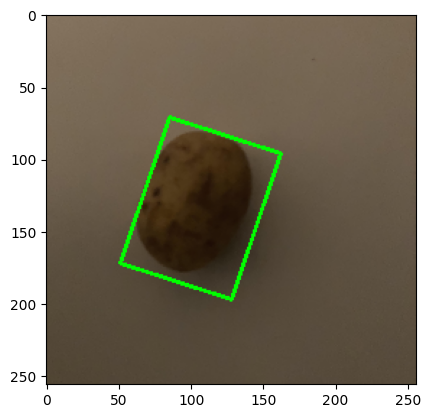

After draw_contours. Box Points in original:  [[ 51 172]
 [ 85  71]
 [162  96]
 [128 197]]
Height: 106.57. width: 80.96
BOX IS ROTATED


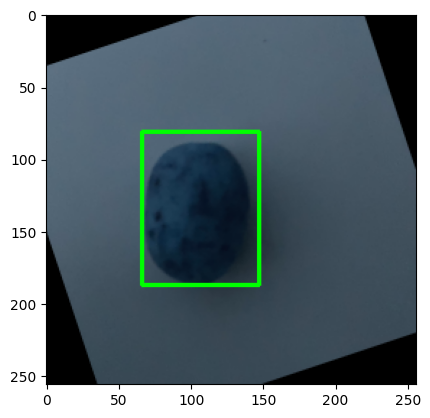

IN CROP from rect**: width: 80 hight 106


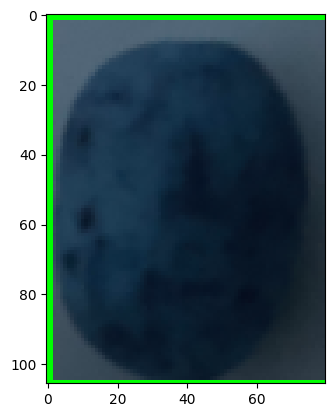

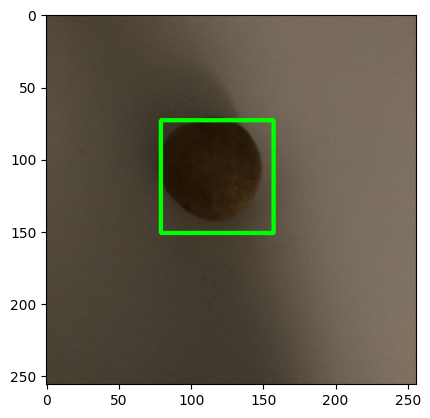

After draw_contours. Box Points in original:  [[ 79  73]
 [157  73]
 [157 151]
 [ 79 151]]
Height: 78.0. width: 78.0
CROP DIRECTLY


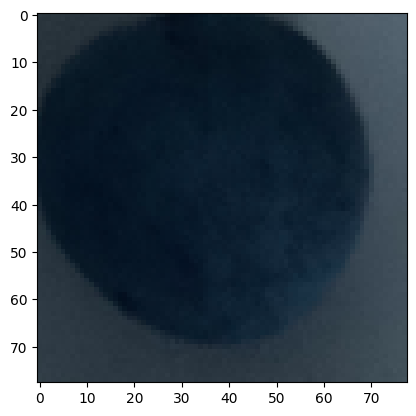

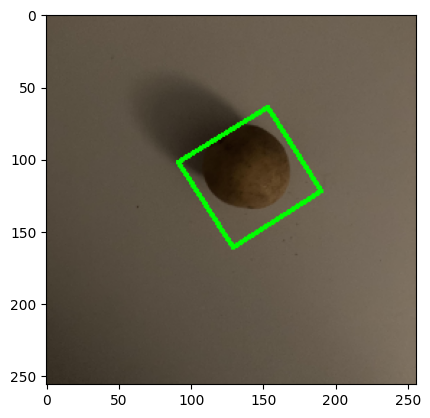

After draw_contours. Box Points in original:  [[ 91 102]
 [153  64]
 [190 122]
 [129 161]]
Height: 72.72. width: 68.8
BOX IS ROTATED


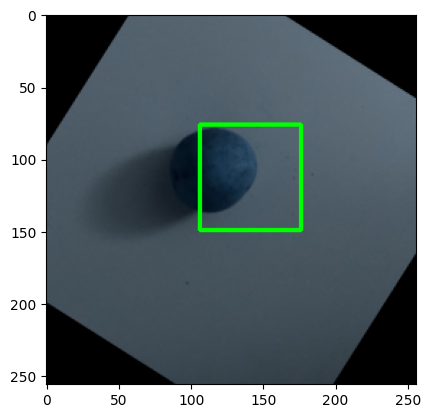

IN CROP from rect**: width: 69 hight 72


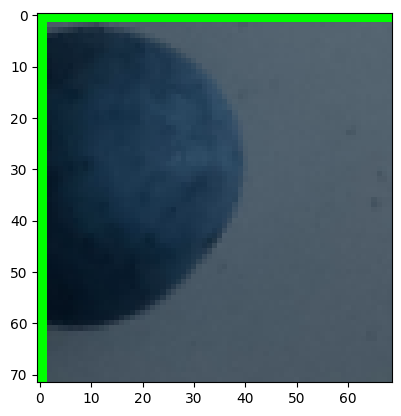

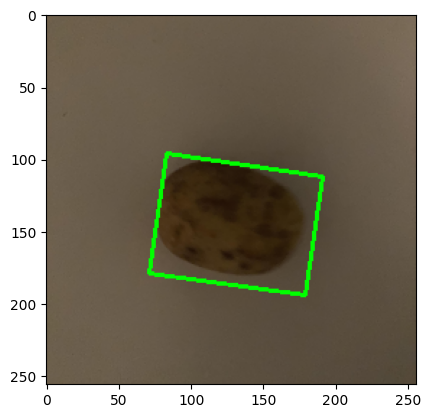

After draw_contours. Box Points in original:  [[ 71 179]
 [ 83  96]
 [191 112]
 [179 194]]
Height: 109.18. width: 83.86
BOX IS ROTATED


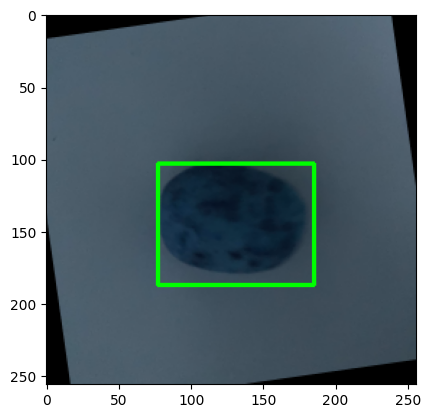

IN CROP from rect**: width: 108 hight 83


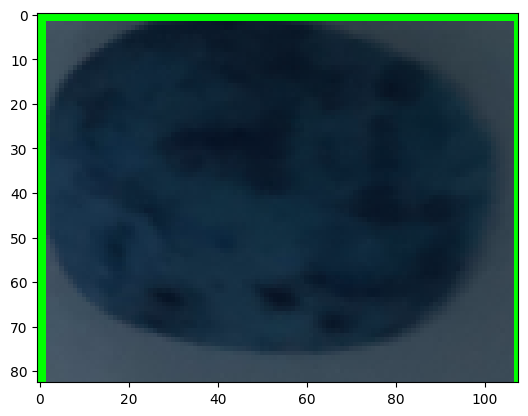

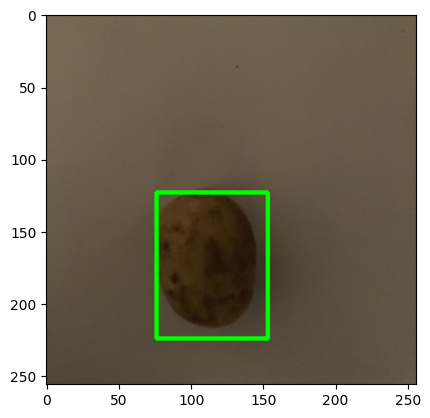

After draw_contours. Box Points in original:  [[ 76 123]
 [153 123]
 [153 224]
 [ 76 224]]
Height: 101.0. width: 77.0
CROP DIRECTLY


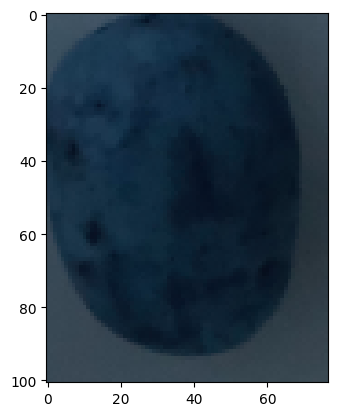

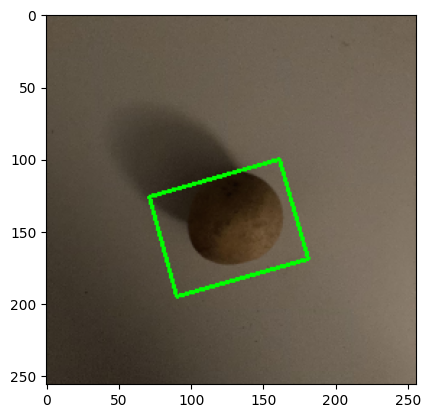

After draw_contours. Box Points in original:  [[ 71 126]
 [161 100]
 [181 169]
 [ 90 195]]
Height: 93.68. width: 71.84
BOX IS ROTATED


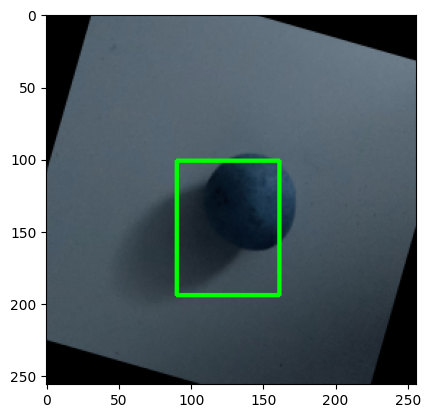

IN CROP from rect**: width: 71 hight 93


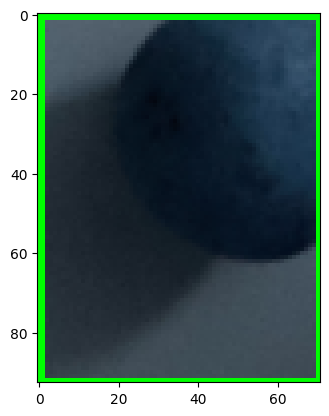

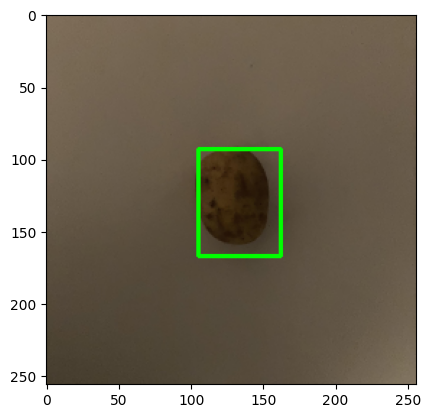

After draw_contours. Box Points in original:  [[105  93]
 [162  93]
 [162 167]
 [105 167]]
Height: 74.0. width: 57.0
CROP DIRECTLY


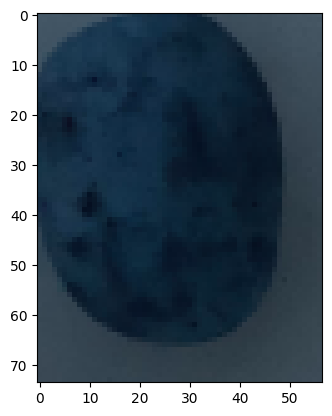

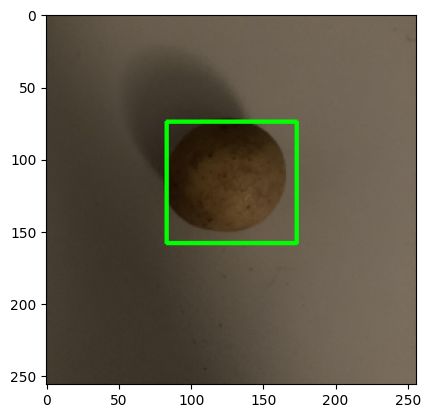

After draw_contours. Box Points in original:  [[ 83  74]
 [173  74]
 [173 158]
 [ 83 158]]
Height: 90.0. width: 84.0
CROP DIRECTLY


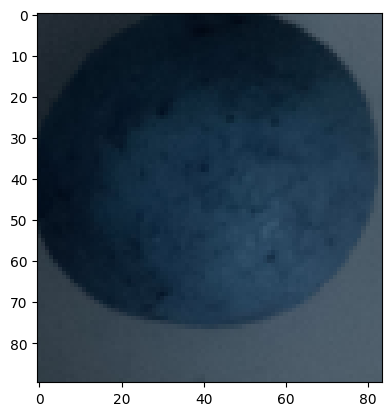

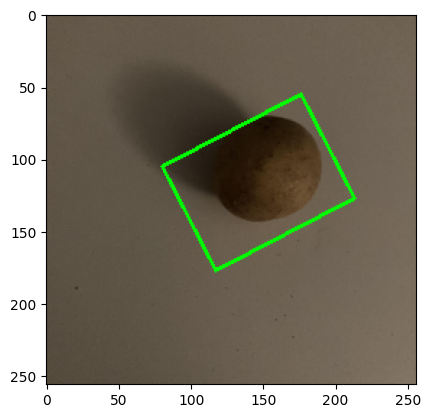

After draw_contours. Box Points in original:  [[ 80 105]
 [176  55]
 [213 127]
 [117 177]]
Height: 108.24. width: 80.95
BOX IS ROTATED


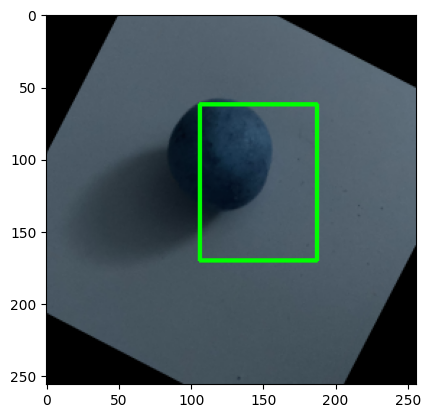

IN CROP from rect**: width: 81 hight 108


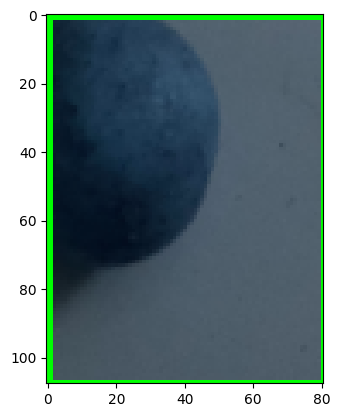

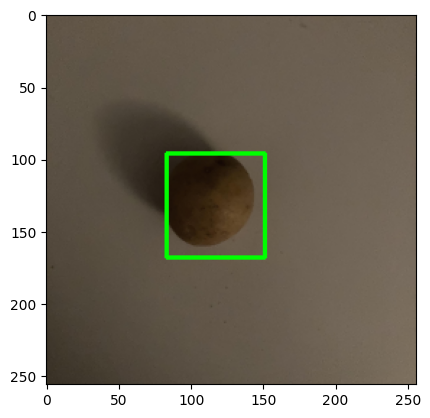

After draw_contours. Box Points in original:  [[ 83  96]
 [151  96]
 [151 168]
 [ 83 168]]
Height: 72.0. width: 68.0
CROP DIRECTLY


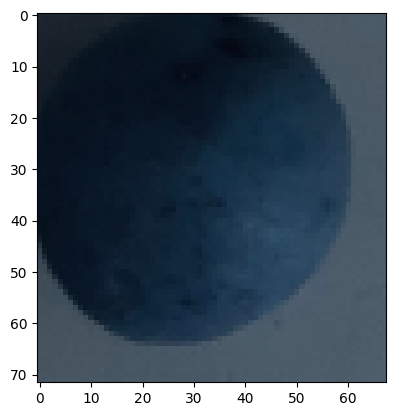

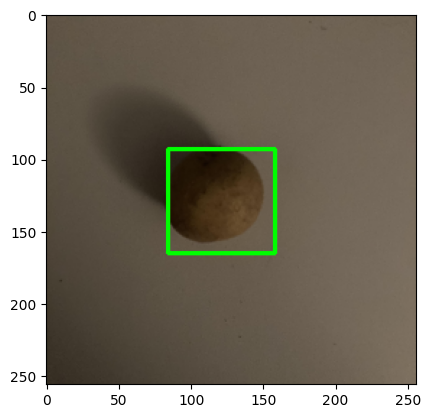

After draw_contours. Box Points in original:  [[ 84  93]
 [158  93]
 [158 165]
 [ 84 165]]
Height: 74.0. width: 72.0
CROP DIRECTLY


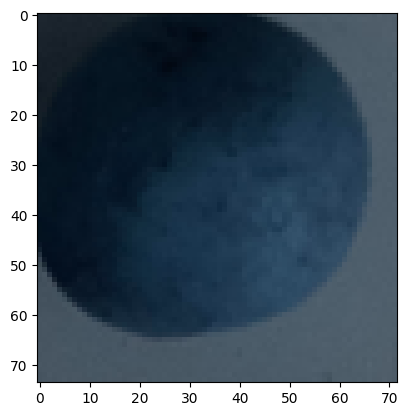

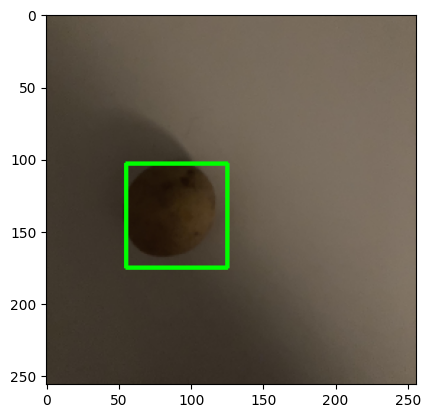

After draw_contours. Box Points in original:  [[ 55 103]
 [125 103]
 [125 175]
 [ 55 175]]
Height: 72.0. width: 70.0
CROP DIRECTLY


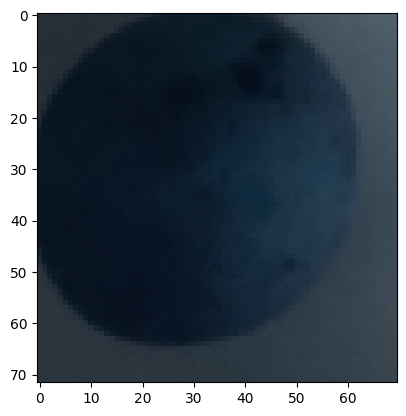

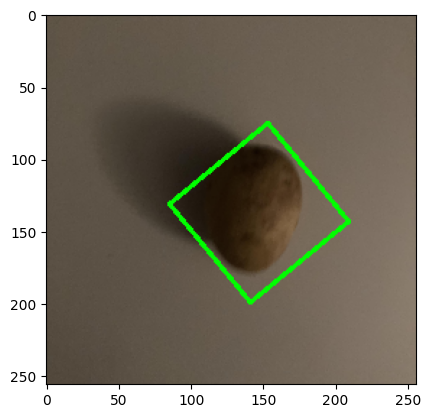

After draw_contours. Box Points in original:  [[ 85 131]
 [153  75]
 [209 143]
 [141 199]]
Height: 88.09. width: 88.09
BOX IS ROTATED


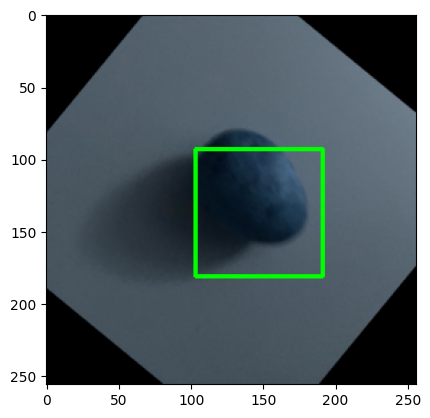

IN CROP from rect**: width: 88 hight 87


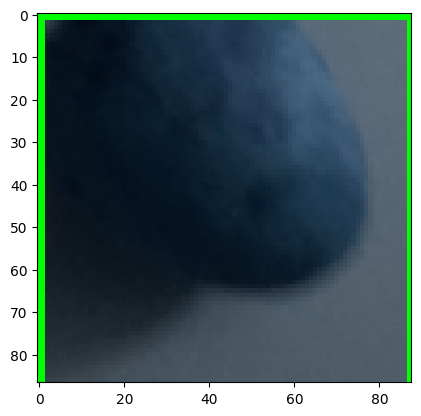

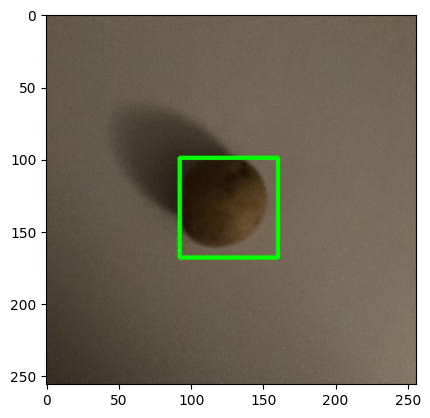

After draw_contours. Box Points in original:  [[ 92  99]
 [160  99]
 [160 168]
 [ 92 168]]
Height: 69.0. width: 68.0
CROP DIRECTLY


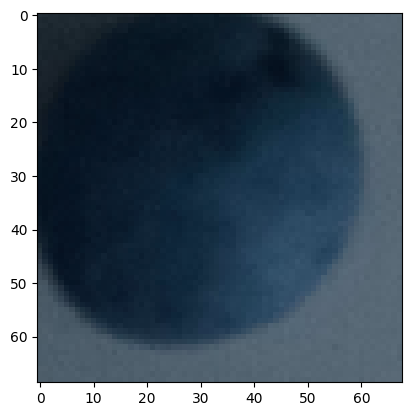

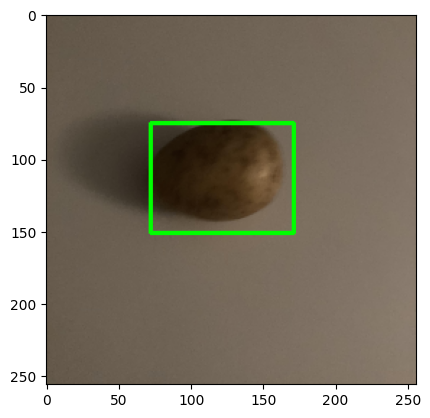

After draw_contours. Box Points in original:  [[ 72  75]
 [171  75]
 [171 151]
 [ 72 151]]
Height: 99.0. width: 76.0
CROP DIRECTLY


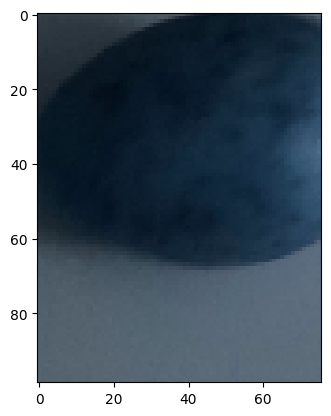

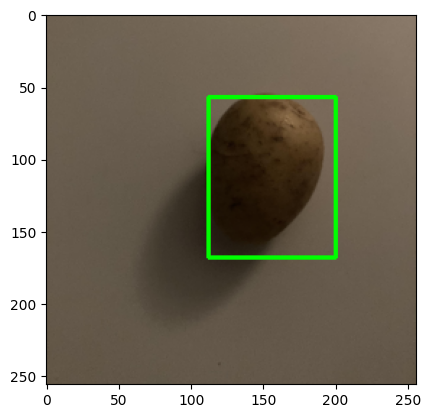

After draw_contours. Box Points in original:  [[112  57]
 [200  57]
 [200 168]
 [112 168]]
Height: 111.0. width: 88.0
CROP DIRECTLY


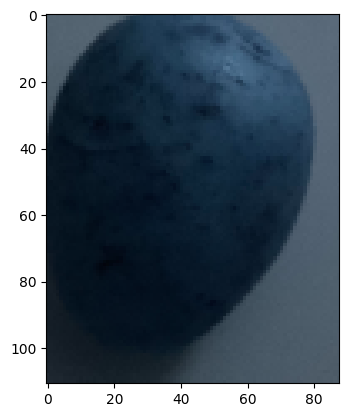

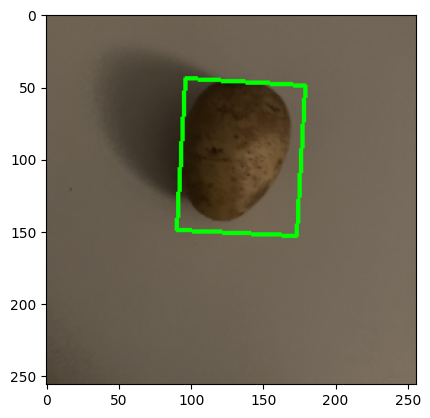

After draw_contours. Box Points in original:  [[ 90 149]
 [ 96  44]
 [179  49]
 [173 153]]
Height: 105.17. width: 83.15
BOX IS ROTATED


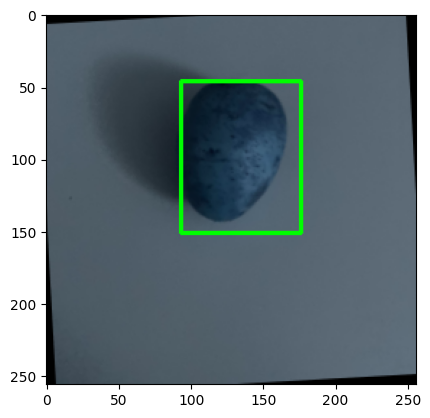

IN CROP from rect**: width: 82 hight 105


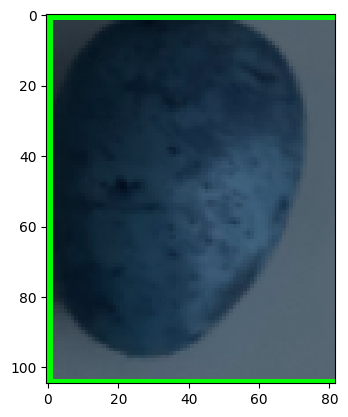

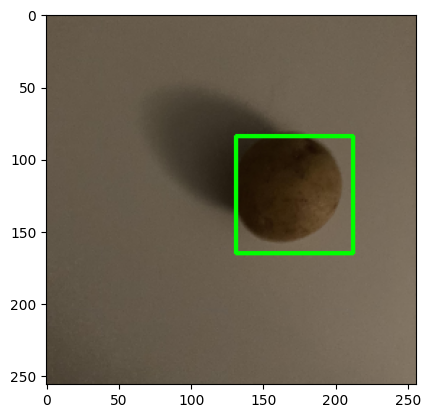

After draw_contours. Box Points in original:  [[131  84]
 [212  84]
 [212 165]
 [131 165]]
Height: 81.0. width: 81.0
CROP DIRECTLY


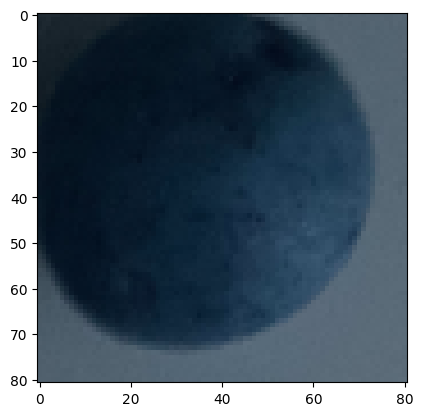

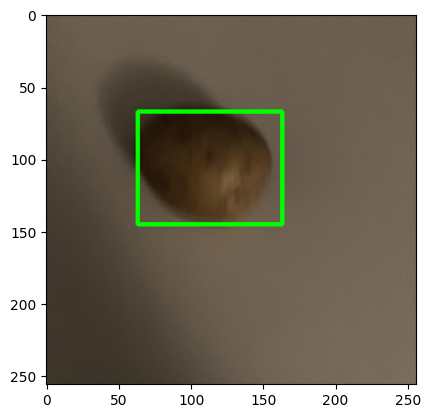

After draw_contours. Box Points in original:  [[ 63  67]
 [163  67]
 [163 145]
 [ 63 145]]
Height: 100.0. width: 78.0
CROP DIRECTLY


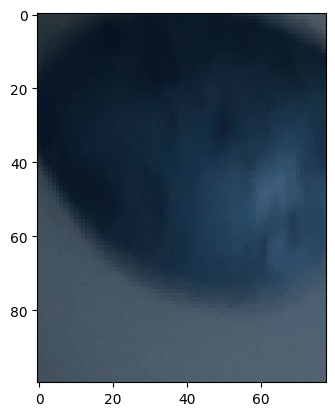

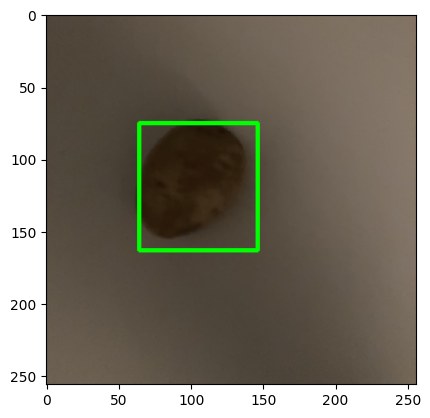

After draw_contours. Box Points in original:  [[ 64  75]
 [146  75]
 [146 163]
 [ 64 163]]
Height: 88.0. width: 82.0
CROP DIRECTLY


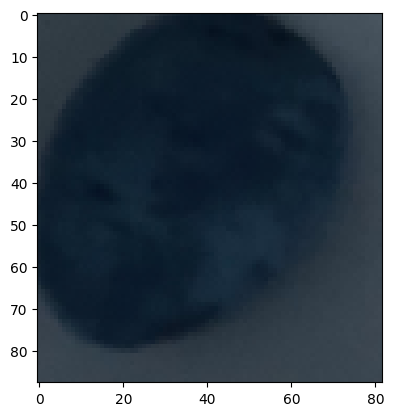

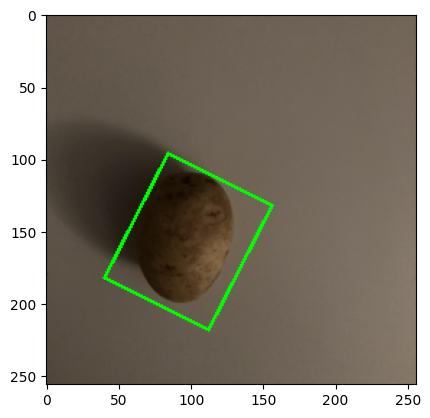

After draw_contours. Box Points in original:  [[ 40 182]
 [ 84  96]
 [156 132]
 [112 218]]
Height: 96.6. width: 80.5
BOX IS ROTATED


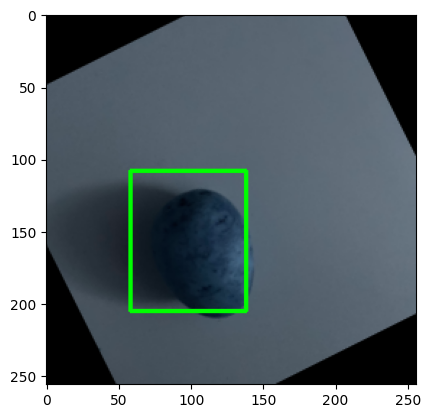

IN CROP from rect**: width: 80 hight 97


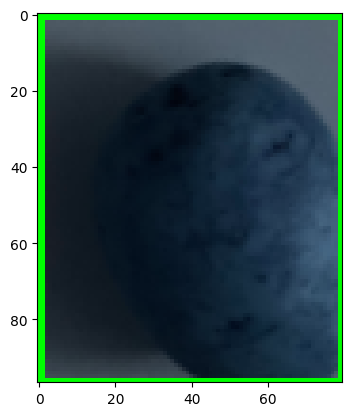

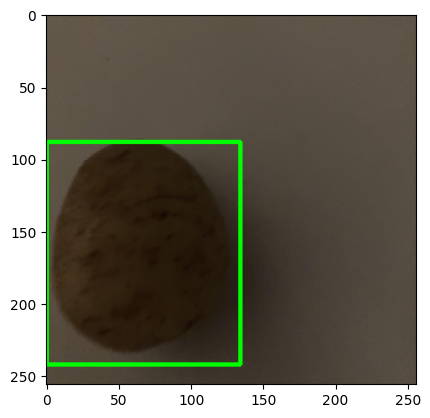

After draw_contours. Box Points in original:  [[  0  88]
 [134  88]
 [134 242]
 [  0 242]]
Height: 154.0. width: 134.0
CROP DIRECTLY


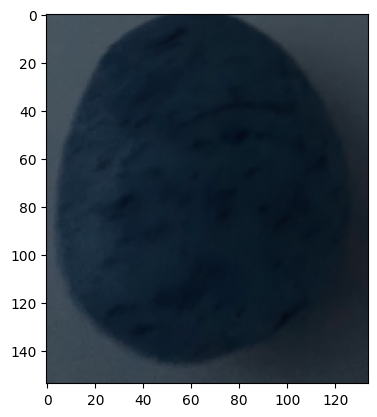

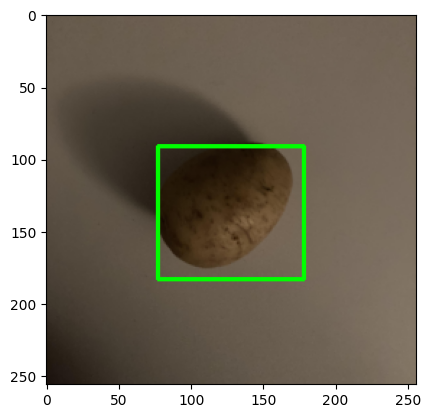

After draw_contours. Box Points in original:  [[ 77  91]
 [178  91]
 [178 183]
 [ 77 183]]
Height: 101.0. width: 92.0
CROP DIRECTLY


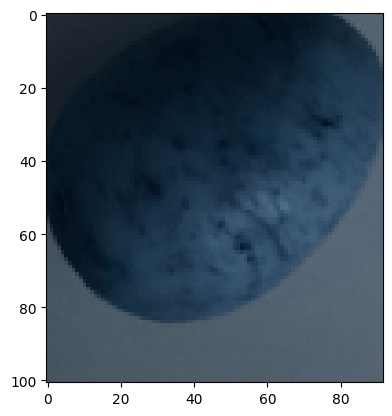

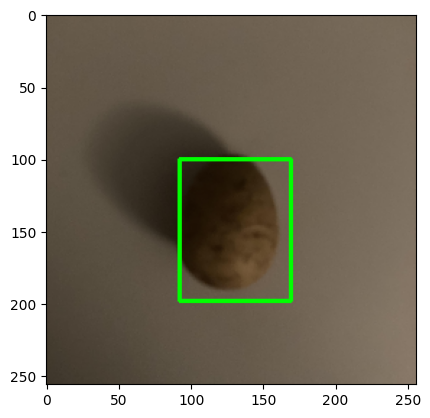

After draw_contours. Box Points in original:  [[ 92 100]
 [169 100]
 [169 198]
 [ 92 198]]
Height: 98.0. width: 77.0
CROP DIRECTLY


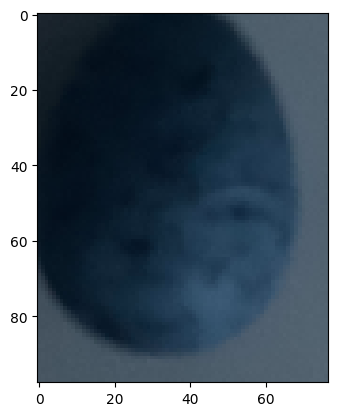

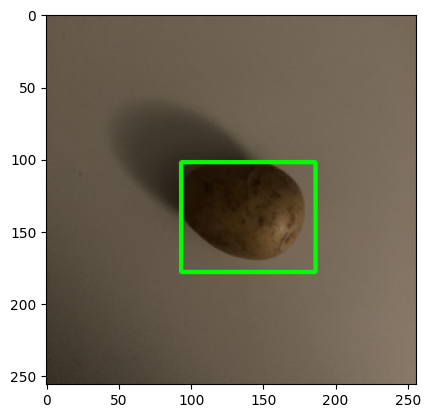

After draw_contours. Box Points in original:  [[ 93 102]
 [186 102]
 [186 178]
 [ 93 178]]
Height: 93.0. width: 76.0
CROP DIRECTLY


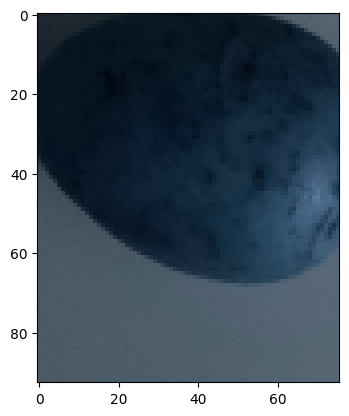

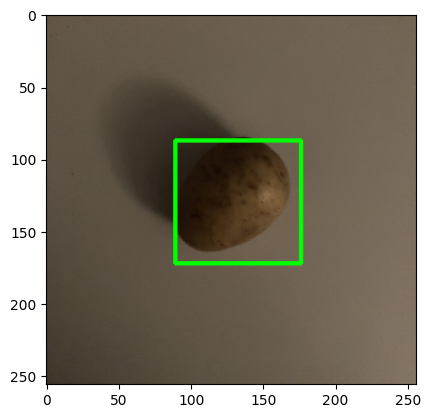

After draw_contours. Box Points in original:  [[ 89  87]
 [176  87]
 [176 172]
 [ 89 172]]
Height: 87.0. width: 85.0
CROP DIRECTLY


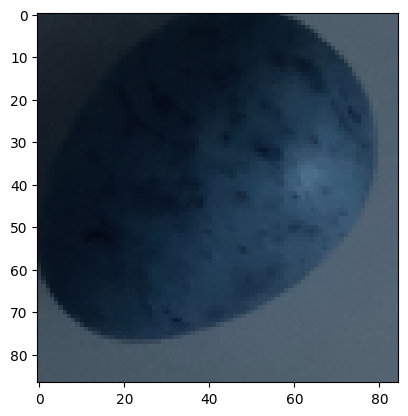

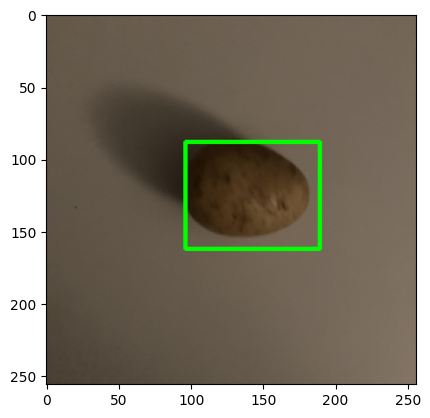

After draw_contours. Box Points in original:  [[ 96  88]
 [189  88]
 [189 162]
 [ 96 162]]
Height: 93.0. width: 74.0
CROP DIRECTLY


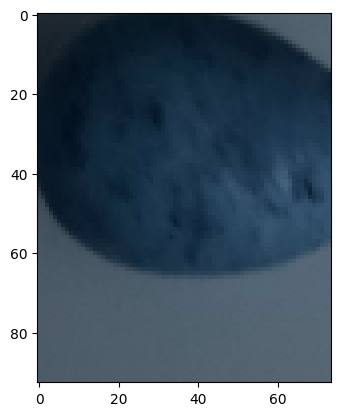

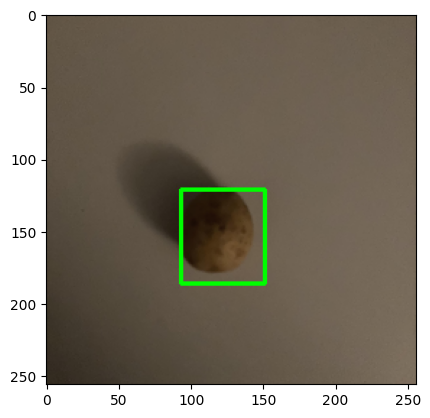

After draw_contours. Box Points in original:  [[ 93 121]
 [151 121]
 [151 186]
 [ 93 186]]
Height: 65.0. width: 58.0
CROP DIRECTLY


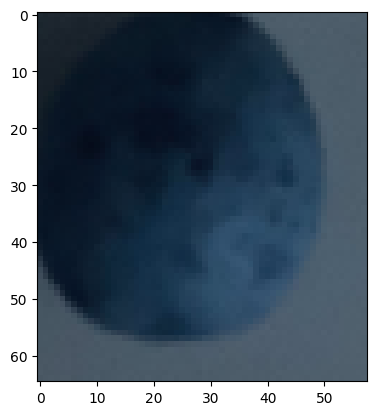

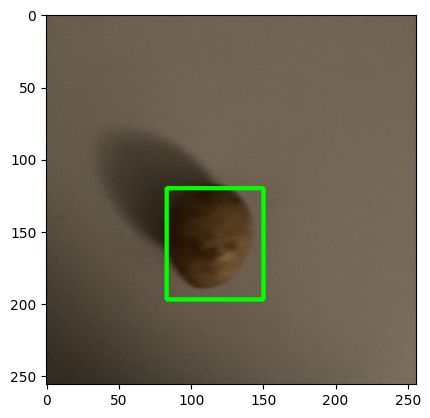

After draw_contours. Box Points in original:  [[ 83 120]
 [150 120]
 [150 197]
 [ 83 197]]
Height: 77.0. width: 67.0
CROP DIRECTLY


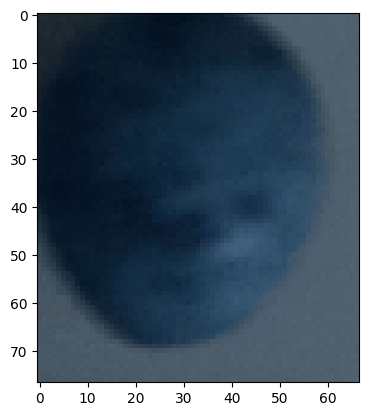

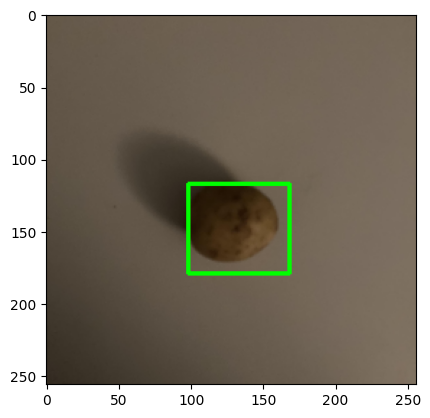

After draw_contours. Box Points in original:  [[ 98 117]
 [168 117]
 [168 179]
 [ 98 179]]
Height: 70.0. width: 62.0
CROP DIRECTLY


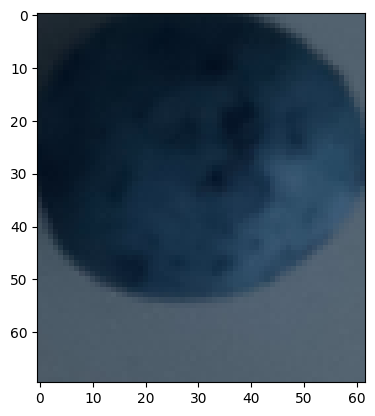

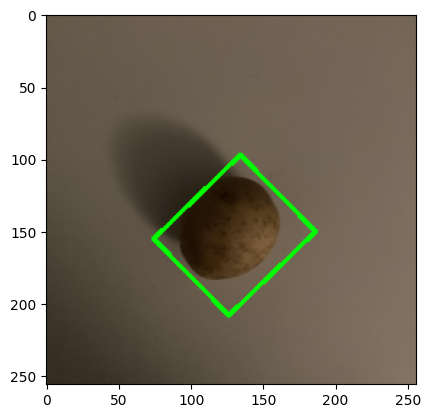

After draw_contours. Box Points in original:  [[ 74 155]
 [134  97]
 [186 150]
 [126 208]]
Height: 83.45. width: 74.25
BOX IS ROTATED


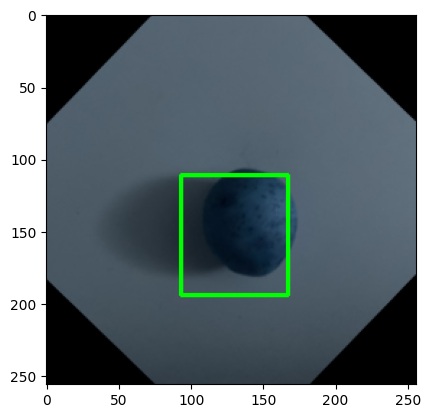

IN CROP from rect**: width: 74 hight 83


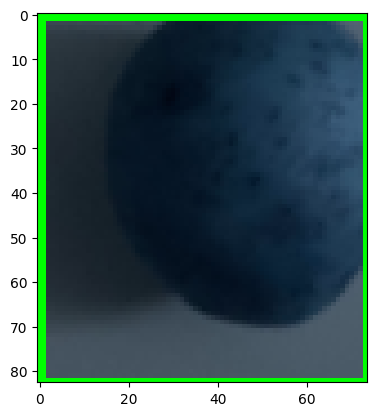

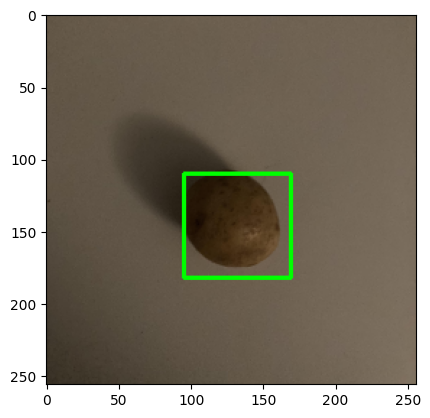

After draw_contours. Box Points in original:  [[ 95 110]
 [169 110]
 [169 182]
 [ 95 182]]
Height: 74.0. width: 72.0
CROP DIRECTLY


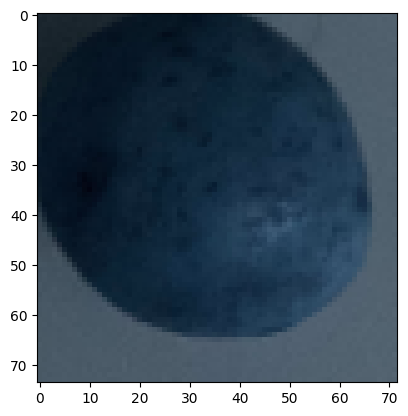

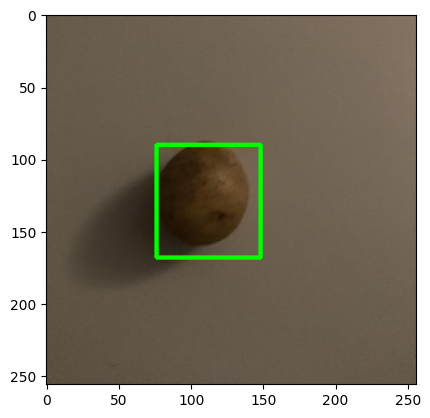

After draw_contours. Box Points in original:  [[ 76  90]
 [148  90]
 [148 168]
 [ 76 168]]
Height: 78.0. width: 72.0
CROP DIRECTLY


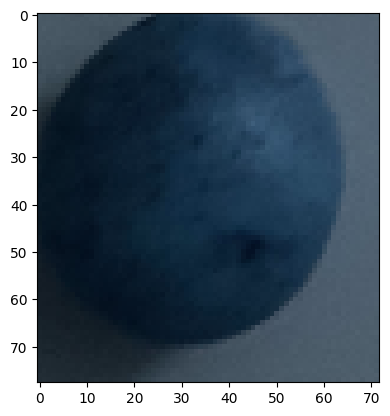

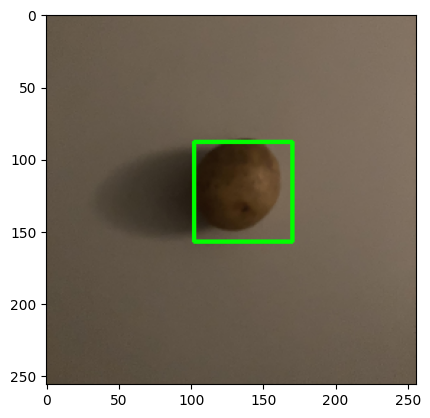

After draw_contours. Box Points in original:  [[102  88]
 [170  88]
 [170 157]
 [102 157]]
Height: 69.0. width: 68.0
CROP DIRECTLY


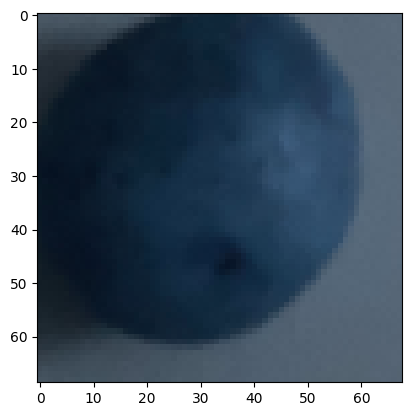

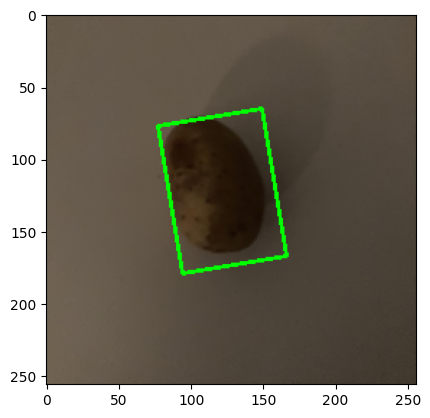

After draw_contours. Box Points in original:  [[ 77  77]
 [149  65]
 [166 167]
 [ 94 179]]
Height: 103.41. width: 72.99
BOX IS ROTATED


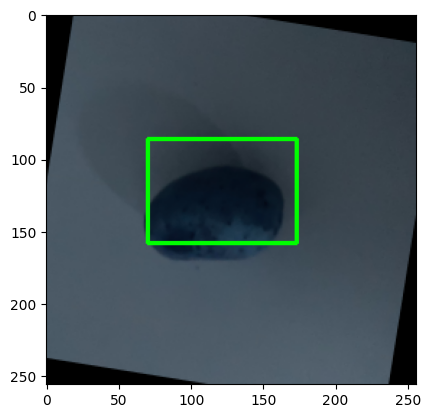

IN CROP from rect**: width: 103 hight 72


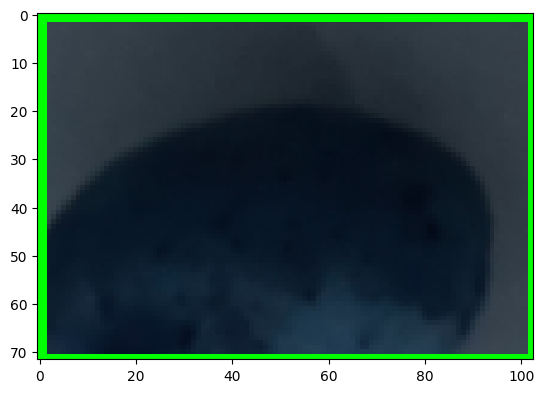

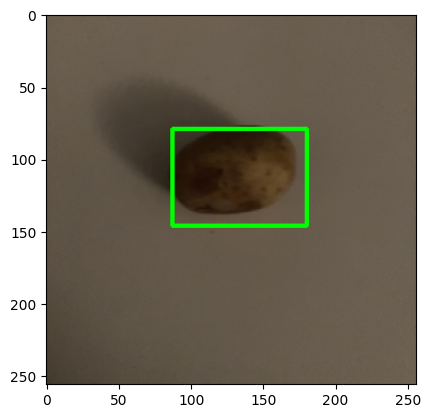

After draw_contours. Box Points in original:  [[ 87  79]
 [180  79]
 [180 146]
 [ 87 146]]
Height: 93.0. width: 67.0
CROP DIRECTLY


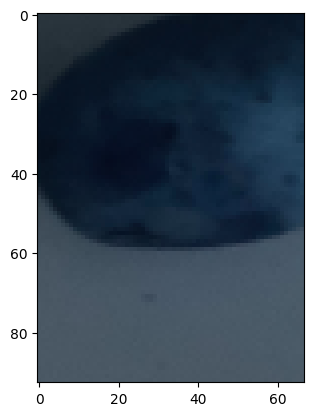

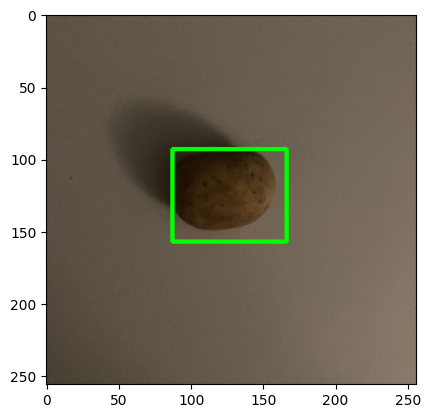

After draw_contours. Box Points in original:  [[ 87  93]
 [166  93]
 [166 157]
 [ 87 157]]
Height: 79.0. width: 64.0
CROP DIRECTLY


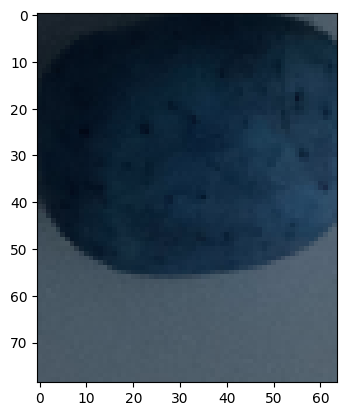

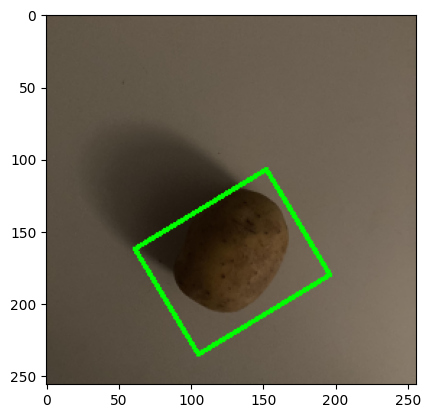

After draw_contours. Box Points in original:  [[ 61 162]
 [152 107]
 [196 180]
 [105 235]]
Height: 106.33. width: 85.23
BOX IS ROTATED


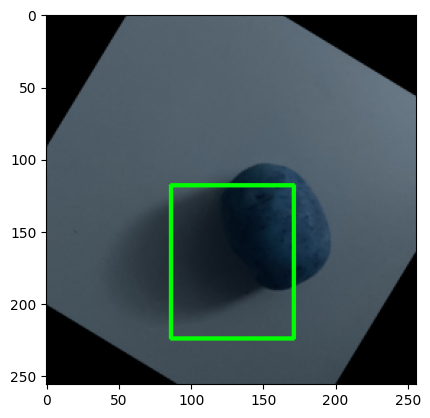

IN CROP from rect**: width: 84 hight 106


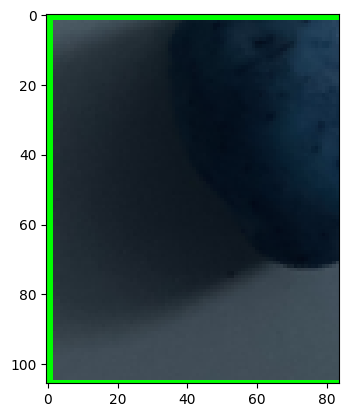

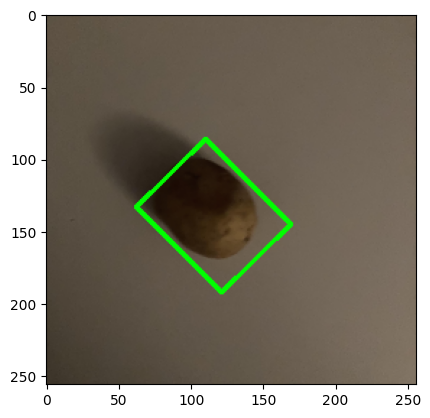

After draw_contours. Box Points in original:  [[ 62 133]
 [110  86]
 [169 145]
 [121 192]]
Height: 83.44. width: 67.18
BOX IS ROTATED


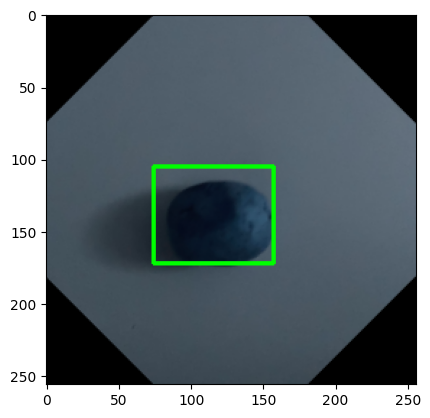

IN CROP from rect**: width: 83 hight 67


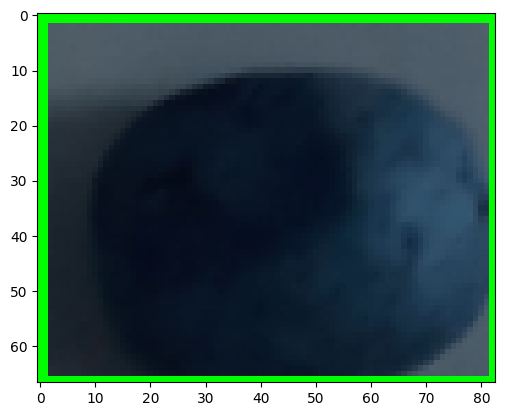

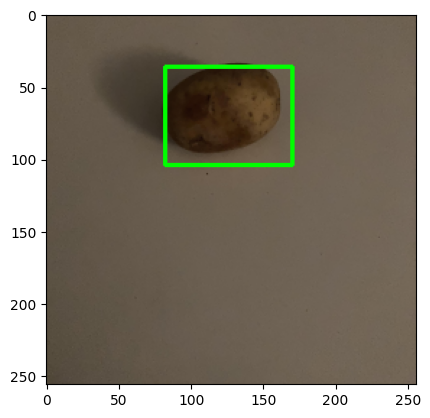

After draw_contours. Box Points in original:  [[ 82  36]
 [170  36]
 [170 104]
 [ 82 104]]
Height: 88.0. width: 68.0
CROP DIRECTLY


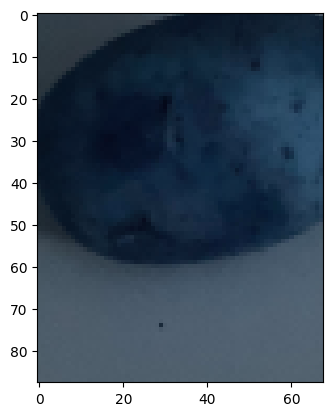

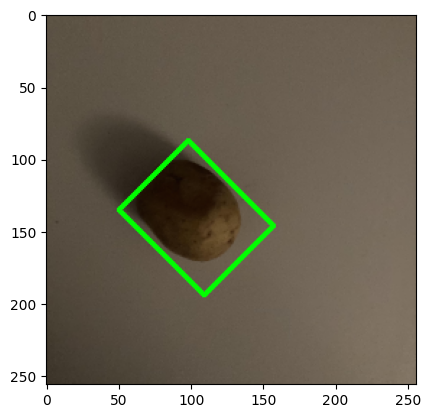

After draw_contours. Box Points in original:  [[ 50 135]
 [ 98  87]
 [157 146]
 [109 194]]
Height: 83.44. width: 67.88
BOX IS ROTATED


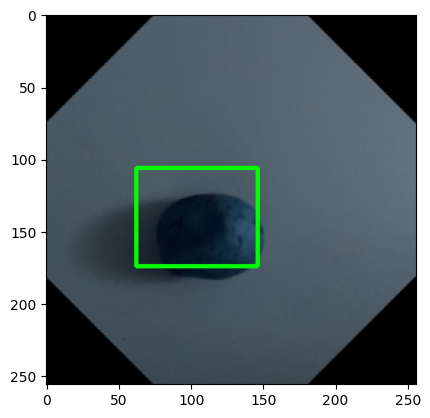

IN CROP from rect**: width: 83 hight 67


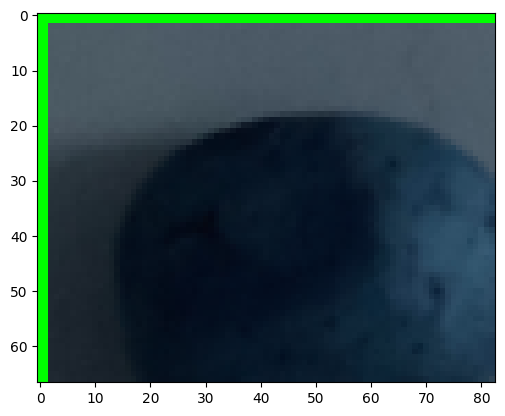

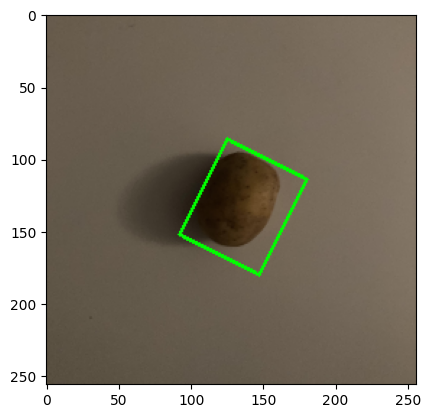

After draw_contours. Box Points in original:  [[ 92 152]
 [125  86]
 [180 114]
 [147 180]]
Height: 73.79. width: 61.72
BOX IS ROTATED


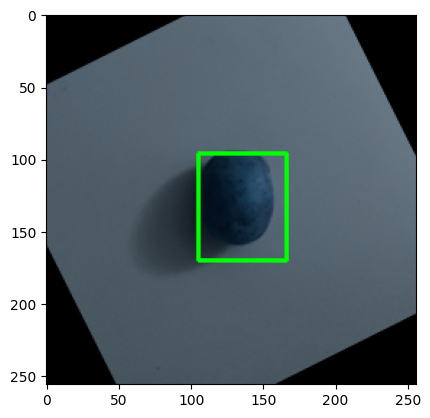

IN CROP from rect**: width: 60 hight 73


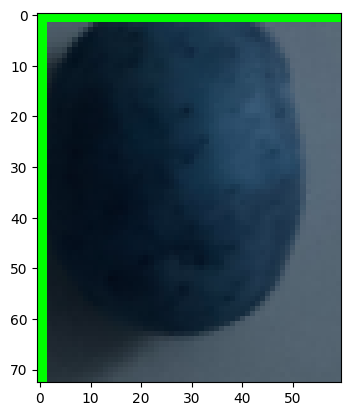

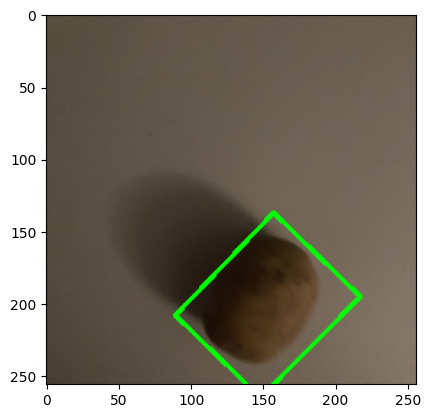

After draw_contours. Box Points in original:  [[ 89 208]
 [157 137]
 [217 195]
 [148 265]]
Height: 98.31. width: 83.45
BOX IS ROTATED


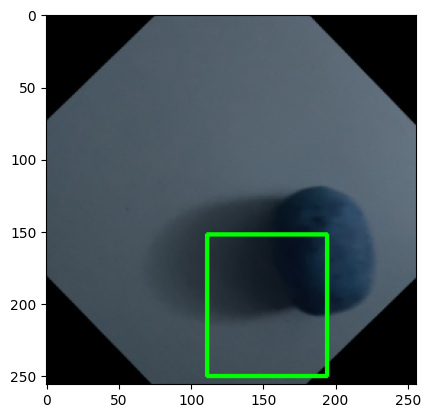

IN CROP from rect**: width: 83 hight 98


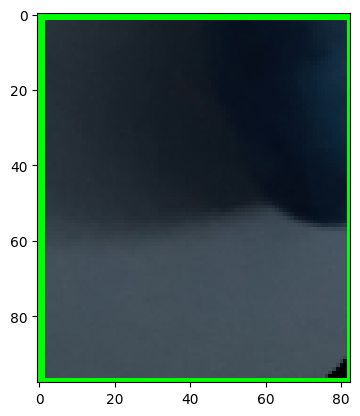

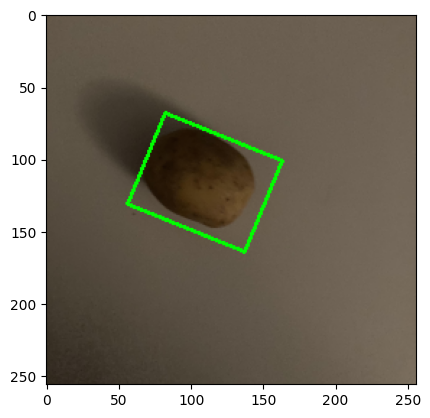

After draw_contours. Box Points in original:  [[ 56 131]
 [ 82  68]
 [163 101]
 [137 164]]
Height: 87.46. width: 68.15
BOX IS ROTATED


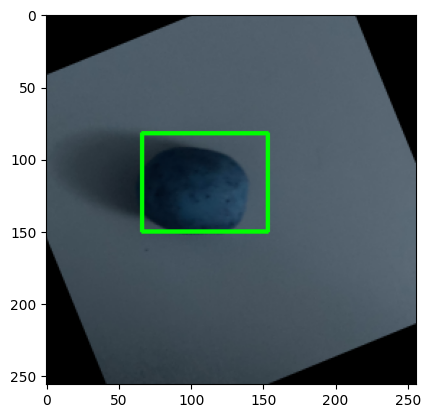

IN CROP from rect**: width: 87 hight 68


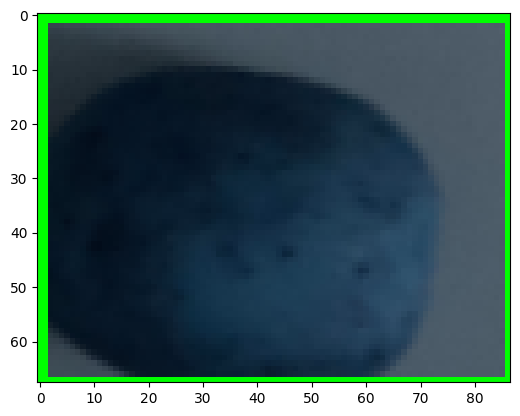

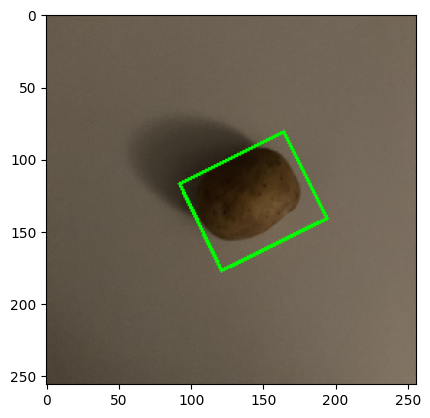

After draw_contours. Box Points in original:  [[ 92 117]
 [164  81]
 [194 141]
 [121 177]]
Height: 80.5. width: 67.08
BOX IS ROTATED


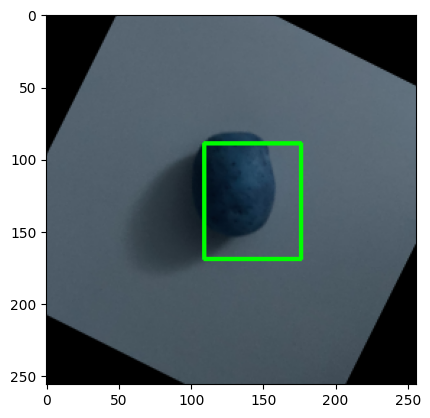

IN CROP from rect**: width: 66 hight 80


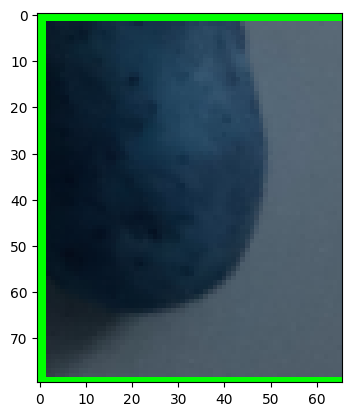

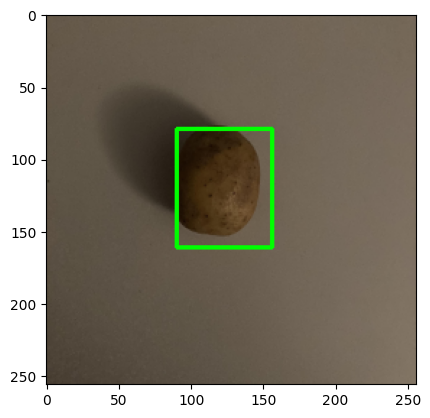

After draw_contours. Box Points in original:  [[ 90  79]
 [156  79]
 [156 161]
 [ 90 161]]
Height: 82.0. width: 66.0
CROP DIRECTLY


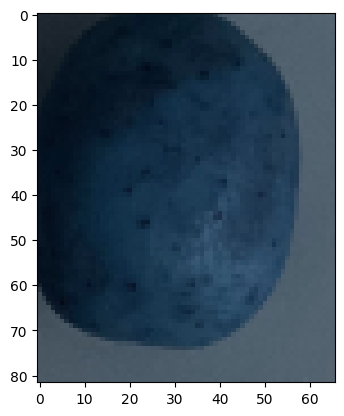

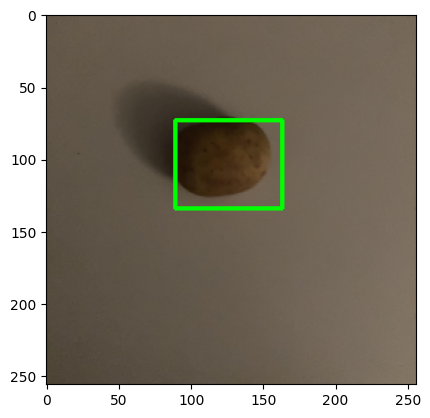

After draw_contours. Box Points in original:  [[ 89  73]
 [163  73]
 [163 134]
 [ 89 134]]
Height: 74.0. width: 61.0
CROP DIRECTLY


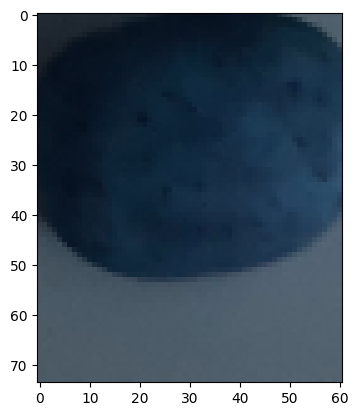

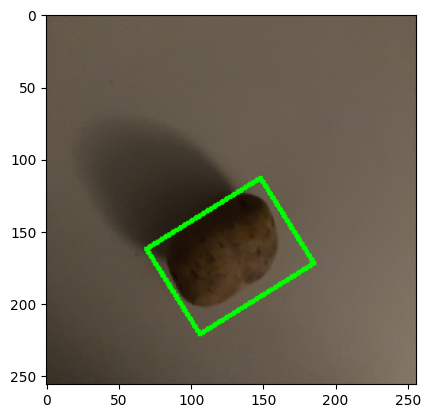

After draw_contours. Box Points in original:  [[ 69 162]
 [148 113]
 [185 172]
 [106 221]]
Height: 92.96. width: 69.64
BOX IS ROTATED


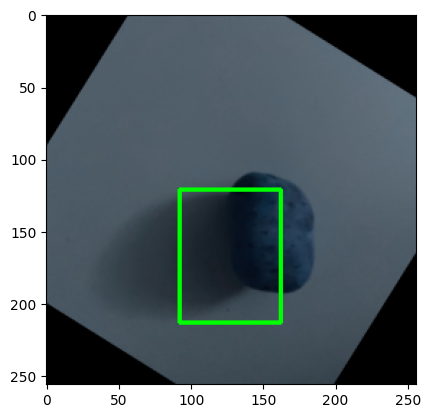

IN CROP from rect**: width: 69 hight 92


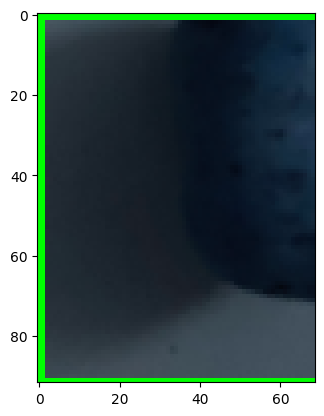

In [15]:
#paths = [f"G:\Meine Ablage\KI_Projekt\Bilder\Zwiebel\zwiebel_{i}.jpg" for i in range(1, 51)]
paths = [f"G:\Meine Ablage\Images_AI_Project\kartoffel_jpg_2\kartoffel_{i}.jpg" for i in range(247, 295)]
for path in paths:
    vegi = cv2.imread(path.replace("\\","/")) # As BGR
    vegi_sq = resize_to_square(vegi)
    rgb, more_than_one_box, box, rect = draw_contours(vegi_sq)
    if more_than_one_box:
        box_size = 500
        while more_than_one_box:
            print("Increase Box Size by 250")
            box_size += 250
            rgb, more_than_one_box, box, rect = draw_contours(vegi_sq, box_size)

    show_image_plt(rgb)
    print("After draw_contours. Box Points in original: ", box)
    heigth, width = get_size_box(box)
    h, w = int(heigth), int(width)
    print(f"Height: {heigth}. width: {width}")

    if not is_box_rotated(box):
        #crop img directly
        #w = int(rect[1][0])
        #h = int(rect[1][1])
        print("CROP DIRECTLY")
        # the top left corner should be the first element in box array
        cropped_vegi = vegi_sq[box[0][1]:box[0][1]+h, box[0][0]:box[0][0]+w]
        
    else:
        cropped_vegi = crop_minAreaRect(vegi_sq, rect, h, w)
    #h, w = [int(i) for i in get_size_box(box)]
    #x, y = int(box[0][0]), int(box[0][1])
    #print(f"H: {h} / W: {w} / X: {x} / Y: {y}")
    show_image_plt(cropped_vegi)

In [241]:
for _ in range(0, 2):
    arr5 = np.zeros((3, 2)) 
    for _ in range(0, 3):
        arr1 = np.array([[1,2], [3, 4], [5,6]])
        arr1 = arr1 + _*10
        arr5 = np.append(arr5, arr1, axis=0)

arr5


array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 1.,  2.],
       [ 3.,  4.],
       [ 5.,  6.],
       [11., 12.],
       [13., 14.],
       [15., 16.],
       [21., 22.],
       [23., 24.],
       [25., 26.]])

In [41]:
box

array([[ 30,  96],
       [215,  77],
       [223, 157],
       [ 38, 175]], dtype=int64)

In [50]:
def crop_minAreaRect(img, rect):
    pic = img.copy()
    # rotate img
    angle = rect[2]
    rows,cols = img.shape[0], img.shape[1]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    img_rot = cv2.warpAffine(img,M,(cols,rows))
    #show_image_plt(img_rot)
    
    # rotate bounding box
    rect0 = (rect[0], rect[1], 0.0) 
    box = cv2.boxPoints(rect0)
    box = np.intp(box)
    print("BOX:", box)
    cv2.drawContours(img_rot, [box], 0, (0, 255, 0), 2)
    #show_image_plt(img_rot)
    #pts = np.int0(cv2.transform(np.array([box]), M))[0]    
    #pts[pts < 0] = 0
    #print("TRANSFORMED BOX: ", pts)
    w = int(rect[1][0])
    h = int(rect[1][1])
    print(f"width: {w} hight {h} in crop")
    # crop
    box = np.clip(box, a_min=[0, img.shape[1]+1], a_max=None)
    print(box)
    img_crop = img_rot[box[1][1]:box[1][1]+h, box[1][0]:box[1][0]+w]

    #img_crop = img_rot[pts[1][1]:pts[0][1], 
    #                   pts[1][0]:pts[2][0]]#

    return img_crop

In [26]:
rect

((127.1334457397461, 126.74307250976562),
 (79.91326904296875, 185.97071838378906),
 84.42780303955078)

In [18]:
a, b = get_size_box(box)
print(a, b)

185.97 80.4


H: 185 / W: 80 / X: 30 / Y: 96
BOX: [[ 87 219]
 [ 87  33]
 [167  33]
 [167 219]]


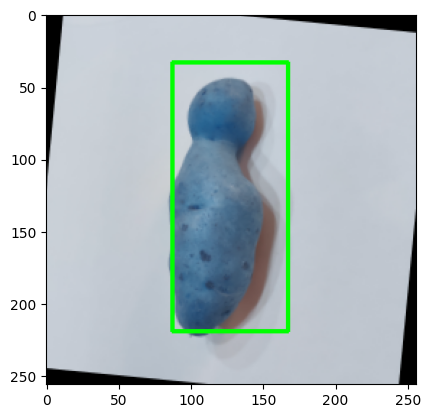

C:\Users\Leon\AppData\Local\Temp\ipykernel_16252\1781433555.py:17: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  pts = np.int0(cv2.transform(np.array([box]), M))[0]


TRANSFORMED BOX:  [[215 178]
 [ 29 160]
 [ 37  80]
 [222  98]]
width: 79 hight 185 in crop


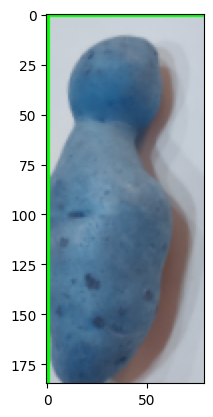

In [40]:
vegi_copy = vegi.copy()
vegi_copy_sq = resize_to_square(vegi_copy)
h, w = [int(i) for i in get_size_box(box)]
x, y = int(box[0][0]), int(box[0][1])
print(f"H: {h} / W: {w} / X: {x} / Y: {y}")
cropped_vegi = crop_minAreaRect(vegi_copy_sq, rect)
show_image_plt(cropped_vegi)